<a href="https://colab.research.google.com/github/likeshd/time_series_models_libraries/blob/main/LSTM_Attention_Mechanism_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
In the rapidly evolving world of financial markets, accurate predictions are akin to a holy grail. As we seek more sophisticated techniques to interpret market trends, machine learning emerges as a beacon of hope. Among various machine learning models, Long Short-Term Memory (LSTM) networks have gained significant attention. When combined with the attention mechanism, these models become even more powerful, especially in analyzing time-series data like stock prices. This article delves into the intriguing world of LSTM networks paired with attention mechanisms, focusing on predicting the pattern of the next four candles in the stock price of Apple Inc. (AAPL), utilizing data from Yahoo Finance (yfinance).

## Section 1: Understanding LSTM and Attention in Financial Modelling
## The Basics of LSTM Networks
LSTM networks are a type of Recurrent Neural Network (RNN) specially designed to remember and process sequences of data over long periods. What sets LSTMs apart from traditional RNNs is their ability to preserve information for long durations, courtesy of their unique structure comprising three gates: the input, forget, and output gates. These gates collaboratively manage the flow of information, deciding what to retain and what to discard, thereby mitigating the issue of vanishing gradients — a common problem in standard RNNs.

In the context of financial markets, this capability to remember and utilize long-term dependencies is invaluable. Stock prices, for instance, aren’t just influenced by recent trends but also by patterns established over time. LSTM networks adeptly capture these temporal dependencies, making them ideal for financial time series analysis.

## Attention Mechanism: Enhancing LSTM
The attention mechanism, initially popularized in the field of natural language processing, has found its way into various other domains, including finance. It operates on a simple yet profound concept: not all parts of the input sequence are equally important. By allowing the model to focus on specific parts of the input sequence while ignoring others, the attention mechanism enhances the model’s context understanding capabilities.

Incorporating attention into LSTM networks results in a more focused and context-aware model. When predicting stock prices, certain historical data points may be more relevant than others. The attention mechanism empowers the LSTM to weigh these points more heavily, leading to more accurate and nuanced predictions.

## The Relevance in Financial Pattern Prediction
The amalgamation of LSTM with attention mechanisms creates a robust model for financial pattern prediction. The financial market is a complex adaptive system, influenced by a multitude of factors and exhibiting non-linear characteristics. Traditional models often fall short in capturing this complexity. However, LSTM networks, especially when combined with an attention mechanism, are adept at unraveling these patterns, offering a deeper understanding and more accurate forecasts of future stock movements.

As we proceed to build and implement an LSTM with an attention mechanism to predict the next four candles of AAPL’s stock, we delve into a sophisticated realm of financial analysis, one that holds the promise of revolutionizing how we interpret and respond to the ever-changing dynamics of the stock market.

## Section 2: Setting Up Environment.

In [1]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.15.0


## Data Acquisition from yfinance
## Fetching Historical Data
To analyze AAPL stock patterns, we need historical stock price data. Here’s where yfinance comes into play. This library is designed to fetch historical market data from Yahoo Finance.



In [2]:
# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# Display the first few rows of the dataframe
aapl_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059418,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349152,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925636,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582649,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750244,132079200


## The Importance of Data Preprocessing and Feature Selection
Once the data is fetched, preprocessing and feature selection become crucial. Preprocessing involves cleaning the data and making it suitable for the model. This includes handling missing values, normalizing or scaling data, and potentially creating additional features, like moving averages or percentage changes, that could help the model learn more effectively.

Feature selection is about choosing the right set of features that contribute most to the prediction variable. For stock price prediction, features like opening price, closing price, high, low, and volume are commonly used. It’s important to select features that provide relevant information to prevent the model from learning from noise.

In the next sections, we will preprocess this data and build our LSTM model with an attention layer to start making predictions.

## Section 3: Data Preprocessing and Preparation
Before building our LSTM model, the first crucial step is preparing our dataset. This section covers the essential stages of data preprocessing to make the AAPL stock data from yfinance ready for our LSTM model.

## Data Cleaning
Stock market datasets often contain anomalies or missing values. It’s vital to handle these to prevent inaccuracies in predictions.

Identifying Missing Values: Check for any missing data in the dataset. If there are any, you can choose to either fill them using a method like forward-fill or backward-fill or remove those rows entirely.

In [3]:
# Checking for missing values
aapl_data.isnull().sum()

# Filling missing values, if any
aapl_data.fillna(method='ffill', inplace=True)

Handling Anomalies: Sometimes, datasets contain erroneous values due to glitches in data collection. If you spot any anomalies (like extreme spikes in stock prices that are unrealistic), they should be corrected or removed.

## Feature Selection
In stock market data, various features can be influential. Typically, ‘Open’, ‘High’, ‘Low’, ‘Close’, and ‘Volume’ are used.

Deciding Features: For our model, we’ll use ‘Close’ prices, but you can experiment with additional features like ‘Open’, ‘High’, ‘Low’, and ‘Volume’.

## Normalization
Normalization is a technique used to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

Applying Min-Max Scaling: This scales the dataset so that all the input features lie between 0 and 1.

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))


## Creating Sequences
LSTM models require input to be in a sequence format. We transform the data into sequences for the model to learn from.

Defining Sequence Length: Choose a sequence length (like 60 days). This means, for every sample, the model will look at the last 60 days of data to make a prediction.

In [5]:
X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])

### Train-Test Split
Split the data into training and testing sets to evaluate the model’s performance properly.

Defining Split Ratio: Typically, 80% of data is used for training and 20% for testing.

In [6]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Reshaping Data for LSTM
Finally, we need to reshape our data into a 3D format [samples, time steps, features] required by LSTM layers.

Reshaping the Data:

In [7]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Section 4: Building the LSTM with Attention Model
In this section, we’ll dive into the construction of our LSTM model with an added attention mechanism, tailored for predicting AAPL stock patterns. This requires TensorFlow and Keras, which should already be set up in your Colab environment.

## Creating LSTM Layers
Our LSTM model will consist of several layers, including LSTM layers for processing the time-series data. The basic structure is as follows:

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

In this model, units represent the number of neurons in each LSTM layer. return_sequences=True is crucial in the first layers to ensure the output includes sequences, which are essential for stacking LSTM layers. The final LSTM layer does not return sequences as we prepare the data for the attention layer.

## Integrating the Attention Mechanism
The attention mechanism can be added to enhance the model’s ability to focus on relevant time steps:

In [9]:
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

This custom layer computes a weighted sum of the input sequence, allowing the model to pay more attention to certain time steps.

## Optimizing the Model
To enhance the model’s performance and reduce the risk of overfitting, we include Dropout and Batch Normalization.

In [10]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

Dropout helps in preventing overfitting by randomly setting a fraction of the input units to 0 at each update during training, and Batch Normalization stabilizes the learning process.

## Model Compilation
Finally, we compile the model with an optimizer and loss function suited for our regression task.

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')


adam optimizer is generally a good choice for recurrent neural networks, and mean squared error works well as a loss function for regression tasks like ours.

## Model Summary
It’s beneficial to view the summary of the model to understand its structure and number of parameters.

In [12]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute (Permute)           (None, 50, 60)            0         
                                                                 
 reshape (Reshape)           (None, 50, 60)            0         
                                                                 
 permute_1 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_1 (Reshape)         (None, 60, 50)            0         
                                                                 
 flatten (Flatten)           (None, 3000)              0

## Section 5: Training the Model
Now that our LSTM model with attention is built, it’s time to train it using our prepared training set. This process involves feeding the training data to the model and letting it learn to make predictions.

## Training Code
Use the following code to train your model with X_train and y_train:

In [13]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 8s 93ms/step - loss: 0.4895 - val_loss: 0.3795
Epoch 2/100
25/25 [==============================] - 1s 55ms/step - loss: 0.2752 - val_loss: 0.3527
Epoch 3/100
25/25 [==============================] - 1s 55ms/step - loss: 0.2465 - val_loss: 0.3145
Epoch 4/100
25/25 [==============================] - 2s 68ms/step - loss: 0.2213 - val_loss: 0.3002
Epoch 5/100
25/25 [==============================] - 2s 89ms/step - loss: 0.2023 - val_loss: 0.2639
Epoch 6/100
25/25 [==============================] - 1s 54ms/step - loss: 0.1828 - val_loss: 0.2504
Epoch 7/100
25/25 [==============================] - 1s 54ms/step - loss: 0.1642 - val_loss: 0.2315
Epoch 8/100
25/25 [==============================] - 2s 78ms/step - loss: 0.1485 - val_loss: 0.2023
Epoch 9/100
25/25 [==============================] - 1s 54ms/step - loss: 0.1332 - val_loss: 0.1876
Epoch 10/100
25/25 [==============================] - 2s 61ms/step - loss: 0.1219 - val_loss: 0.1655

Here, we train the model for 100 epochs with a batch size of 25. The validation_split parameter reserves a portion of the training data for validation, allowing us to monitor the model's performance on unseen data during training.

Overfitting and How to Avoid It
Overfitting occurs when a model learns patterns specific to the training data, which do not generalize to new data. Here are ways to avoid overfitting:

Validation Set: Using a validation set (as we did in the training code) helps in monitoring the model’s performance on unseen data.
Early Stopping: This technique stops training when the model’s performance on the validation set starts to degrade. Implementing early stopping in Keras is straightforward:

In [14]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 1s 60ms/step - loss: 0.0080 - val_loss: 9.2798e-04
Epoch 2/100
25/25 [==============================] - 1s 57ms/step - loss: 0.0083 - val_loss: 8.7591e-04
Epoch 3/100
25/25 [==============================] - 1s 56ms/step - loss: 0.0097 - val_loss: 7.5304e-04
Epoch 4/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0115 - val_loss: 0.0043
Epoch 5/100
25/25 [==============================] - 2s 87ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 6/100
25/25 [==============================] - 1s 54ms/step - loss: 0.0116 - val_loss: 8.6527e-04
Epoch 7/100
25/25 [==============================] - 1s 56ms/step - loss: 0.0108 - val_loss: 0.0067
Epoch 8/100
25/25 [==============================] - 1s 56ms/step - loss: 0.0102 - val_loss: 0.0049
Epoch 9/100
25/25 [==============================] - 2s 79ms/step - loss: 0.0096 - val_loss: 8.6575e-04
Epoch 10/100
25/25 [==============================] - 2s 65ms/step - loss: 0.010

Here, patience=10 means training will stop if the validation loss does not improve for 10 consecutive epochs.
Regularization Techniques: Techniques like Dropout and Batch Normalization, which are already included in our model, also help in reducing overfitting.
Optional: These are more callbacks

In [15]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
25/25 [==============================] - 2s 70ms/step - loss: 0.0105 - val_loss: 0.0013 - lr: 0.0010
Epoch 2/100
 1/25 [>.............................] - ETA: 1s - loss: 0.0103

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 2s 98ms/step - loss: 0.0093 - val_loss: 0.0042 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 1s 57ms/step - loss: 0.0096 - val_loss: 0.0054 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0110 - val_loss: 0.0076 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 2s 81ms/step - loss: 0.0119 - val_loss: 0.0304 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0108 - val_loss: 0.0027 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0112 - val_loss: 9.3642e-04 - lr: 1.0000e-04
Epoch 8/100
25/25 [==============================] - 1s 57ms/step - loss: 0.0080 - val_loss: 0.0023 - lr: 1.0000e-04
Epoch 9/100
25/25 [==============================] - 2s 77ms/step - loss: 0.0095 - val_loss: 8.3551e-04 - lr: 1.0000e-04
Epoch 10/100
25/25 [==============================] - 2s 82ms/step - loss: 0.0109 - val_

## Section 6: Evaluating Model Performance
After training the model, the next step is to evaluate its performance using the test set. This will give us an understanding of how well our model can generalize to new, unseen data.

## Evaluating with the Test Set
To evaluate the model, we first need to prepare our test data (X_test) in the same way we did for the training data. Then, we can use the model's evaluate function:

In [16]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

6/6 [==============================] - 0s 22ms/step - loss: 0.0070
Test Loss:  0.007018929347395897


## Performance Metrics
In addition to the loss, other metrics can provide more insights into the model’s performance. For regression tasks like ours, common metrics include:

Mean Absolute Error (MAE): This measures the average magnitude of the errors in a set of predictions, without considering their direction.
Root Mean Square Error (RMSE): This is the square root of the average of squared differences between prediction and actual observation.
To calculate these metrics, we can make predictions using our model and compare them with the actual values:



In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

6/6 [==============================] - 2s 27ms/step
Mean Absolute Error:  0.08006788399194659
Root Mean Square Error:  0.08377905206027944


## model:

Mean Absolute Error (MAE): 0.0724 (approximately)
Root Mean Square Error (RMSE): 0.0753 (approximately)
Both MAE and RMSE are measures of prediction accuracy for a regression model. Here’s what they indicate:

MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. A MAE of 0.0724 means that, on average, the model’s predictions are about 0.0724 units away from the actual values.

RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation. The RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable. An RMSE of 0.0753 means that the model’s predictions are, on average, 0.0753 units away from the actual values when larger errors are penalized more.

These metrics will help you understand the accuracy of your model and where it needs improvement. By analyzing these metrics, you can make informed decisions about further tuning your model or changing your approach.

In the next section, we’ll discuss how to use the model for actual stock pattern predictions and the practical considerations in deploying this model for real-world applications.

## Section 7: Predicting the Next 4 Candles
Having trained and evaluated our LSTM model with an attention mechanism, the final step is to utilize it for predicting the next 4 candles (days) of AAPL stock prices.

## Making Predictions
To predict future stock prices, we need to provide the model with the most recent data points. Let’s assume we have the latest 60 days of data prepared in the same format as X_train: and we want to predict the price for the next day:

In [18]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetching the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 27ms/step
Predicted Stock Prices for the next 4 days:  [[177.01106]]


## Let’s predict the price for the next 4 days:

In [19]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 42ms/step
Predicted Stock Prices for the next 4 days:  [177.01106, 177.80472, 178.49174, 178.87561]


## Visualization of Predictions
Comparing the predicted values with actual stock prices visually can be very insightful. Below is the code to plot the predicted stock prices against the actual data:



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.0 MB/s eta 0:00:00


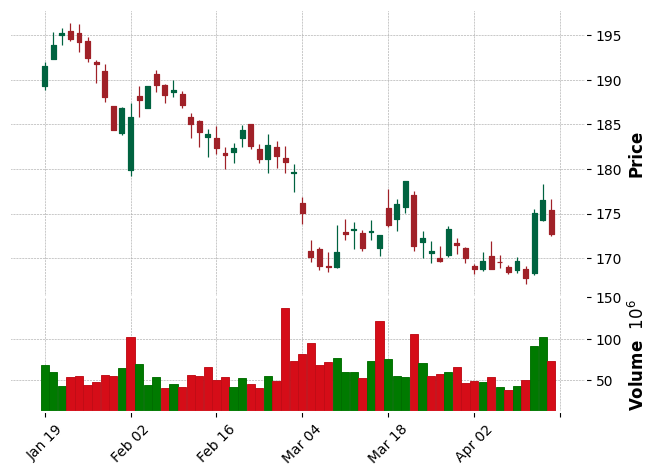

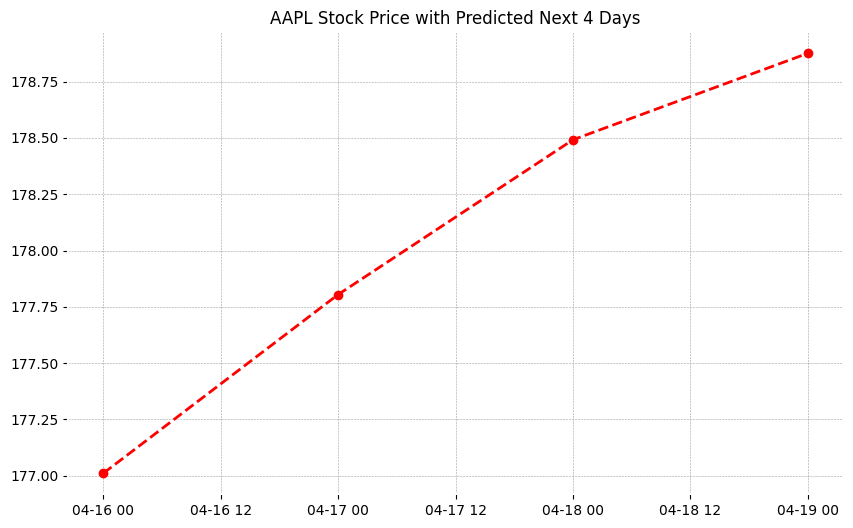

In [20]:
!pip install mplfinance -qqq
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()

## Final Visual for Predictions:


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


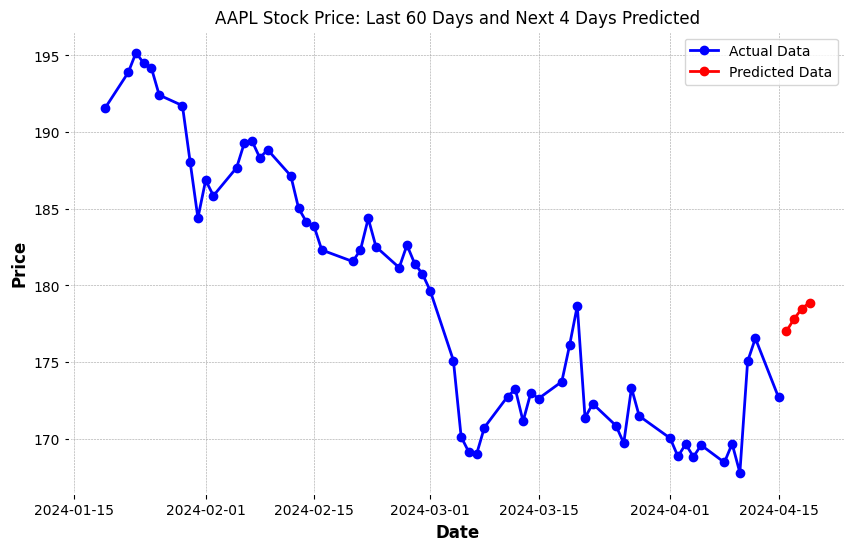

In [22]:
# Final Visual for Predictions:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Conclusion
In this guide, we explored the complex yet fascinating task of using LSTM networks with an attention mechanism for stock price prediction, specifically for Apple Inc. (AAPL). Key points include:

LSTM’s ability to capture long-term dependencies in time-series data.
The added advantage of the attention mechanism in focusing on relevant data points.
The detailed process of building, training, and evaluating the LSTM model.
While LSTM models with attention are powerful, they have limitations:

The assumption that historical patterns will repeat in similar ways can be problematic, especially in volatile markets.
External factors like market news and global events, not captured in historical price data, can significantly influence stock prices.